In [1]:
%run PreProcessing.ipynb

Current Progress: 100.0 %


In [2]:
print(f"The old training dataframe shape: {summary_data_avg.shape}")

iso = IsolationForest(max_samples=500, random_state = 10, contamination= 'auto')
preds = iso.fit_predict(summary_data_avg[['d_lin',
                                          's_lin',
                                          'pp2m2',
                                          'sand',
                                          'silt',
                                          'clay',
                                          'organic_matter',
                                          'heat_units',
                                          'solar_radiation',]]
                        )

totalOutliers=0

for pred in preds:
    if pred == -1:
        totalOutliers=totalOutliers+1
        
print("Total number of outliers identified is: ",totalOutliers)

filtered_array = []
unfiltered_array = []
for element in preds:
  if element != -1:
    filtered_array.append(True)
    unfiltered_array.append(False)
  else:
    filtered_array.append(False)
    unfiltered_array.append(True)

summary_data_avg_outliers = summary_data_avg[unfiltered_array]

summary_data_avg = summary_data_avg[filtered_array]

print(f"The new training dataframe shape: {summary_data_avg.shape}")

The old training dataframe shape: (3197, 25)
Total number of outliers identified is:  634
The new training dataframe shape: (2563, 25)


In [3]:
for i in zone_data.index:
    try:
        method = zone_data.loc[i, 'method']
        inputs = zone_data.loc[i, 'inputs']
        variety = zone_data.loc[i, 'variety']
        protection = zone_data.loc[i, 'protection']

        df = filter_data(summary_data_avg, method, inputs, variety)
        X = df[['solar_radiation', 'heat_units', 'pp2m2', 'organic_matter', 'protection_Fleece', 'protection_None', 'protection_Poly']]
        y_dl = df['d_lin']
        y_sd = df['s_lin']

        reg_dl = LinearRegression(normalize = True).fit(X, y_dl)
        solar_radiation_dl_coef = reg_dl.coef_[0]
        heat_units_dl_coef = reg_dl.coef_[1]

        reg_sd = LinearRegression(normalize = True).fit(X, y_sd) 
        solar_radiation_sd_coef = reg_sd.coef_[0]
        heat_units_sd_coef = reg_sd.coef_[1]

        zone_data.loc[i, 'est_mean_diameter_gain'] = (solar_radiation_dl_coef*(zone_data.loc[i, 'remaining_solar'])) + (heat_units_dl_coef*(zone_data.loc[i, 'remaining_heat']))
        zone_data.loc[i, 'est_std_dev_diameter_gain'] = (solar_radiation_sd_coef*(zone_data.loc[i, 'remaining_solar'])) + (heat_units_sd_coef*(zone_data.loc[i, 'remaining_heat']))
    except:
        zone_data.loc[i, 'est_mean_diameter_gain'] = 0
        zone_data.loc[i, 'est_std_dev_diameter_gain'] = 0
    

In [4]:
zone_data['est_mean_diameter'] = (zone_data['max_mean_diameter_lin'] + zone_data['est_mean_diameter_gain'])**(1/linearisation_coef)
zone_data['est_std_dev_diameter'] = (zone_data['max_std_dev_diameter_lin'] + zone_data['est_std_dev_diameter_gain'])**(1/linearisation_coef)

print(zone_data.info())
zone_data.to_csv('prediction_db.csv', index = False)
zone_data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   field                      755 non-null    object        
 1   zone                       755 non-null    int32         
 2   planting_date              755 non-null    datetime64[ns]
 3   variety                    755 non-null    object        
 4   method                     755 non-null    object        
 5   inputs                     755 non-null    object        
 6   protection                 755 non-null    object        
 7   planting_rate              755 non-null    int64         
 8   sand                       755 non-null    int64         
 9   silt                       755 non-null    int64         
 10  clay                       755 non-null    int64         
 11  organic_matter             755 non-null    float64       
 12  harvest_

,field,zone,planting_date,variety,method,inputs,protection,planting_rate,sand,silt,clay,organic_matter,harvest_date,fieldzone,fieldvariety,mean_pp2m2,max_sample_date,max_mean_diameter_lin,max_std_dev_diameter_lin,max_heat,max_solar,remaining_heat,remaining_solar,establishment,est_mean_diameter_gain,est_std_dev_diameter_gain,est_mean_diameter,est_std_dev_diameter
750,RH33,8,2021-07-23,Laston,Bare Roots,Conventional,None,200000,32,49,19,3.0,NaT,RH33 - 8,RH33 - Laston,40.0,2021-10-07 00:00:00,4.705536,1.940368,1848.0,505887.0,303.854836,107525.032143,1.0000,0.0,0.0,11.917209,2.888115
751,RH33,9,2021-07-23,Laston,Bare Roots,Conventional,None,200000,32,49,19,3.0,NaT,RH33 - 9,RH33 - Laston,39.5,2021-10-07 00:00:00,4.732662,1.836876,1848.0,505887.0,303.854836,107525.032143,0.9875,0.0,0.0,12.027317,2.645622
752,RH33,10,2021-08-01,Harston,Bare Roots,Conventional,None,200000,32,49,19,3.0,NaT,RH33 - 10,RH33 - Harston,38.0,2021-10-07 00:00:00,4.882924,1.584637,1492.0,423185.0,303.854836,107525.032143,0.9500,0.0,0.0,12.644103,2.088756
753,RH33,11,2021-08-01,Harston,Bare Roots,Conventional,None,200000,32,49,19,3.0,NaT,RH33 - 11,RH33 - Harston,36.0,2021-10-07 00:00:00,4.939664,1.521555,1492.0,423185.0,303.854836,107525.032143,0.9000,0.0,0.0,12.880000,1.957313
754,RH33,12,2021-08-01,Harston,Bare Roots,Conventional,None,200000,32,49,19,3.0,NaT,RH33 - 12,RH33 - Harston,36.5,2021-10-07 00:00:00,5.264107,2.042233,1492.0,423185.0,303.854836,107525.032143,0.9125,0.0,0.0,14.260000,3.134502


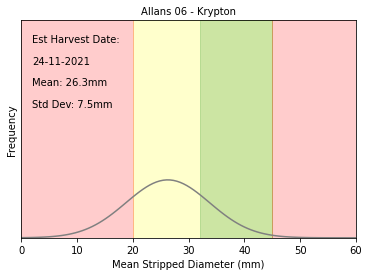

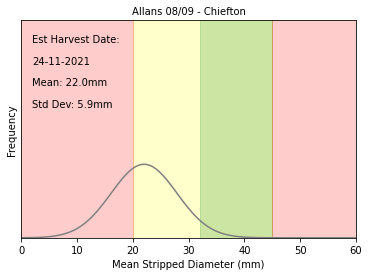

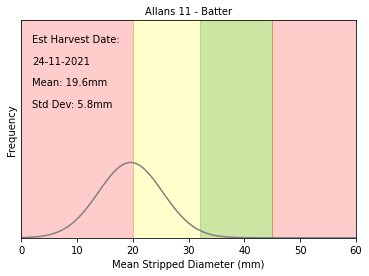

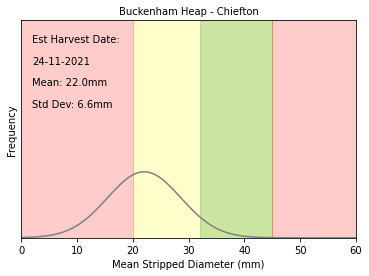

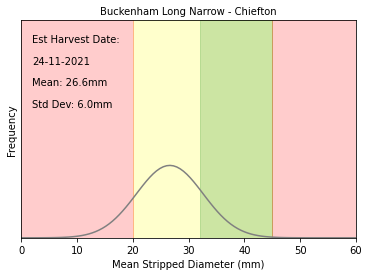

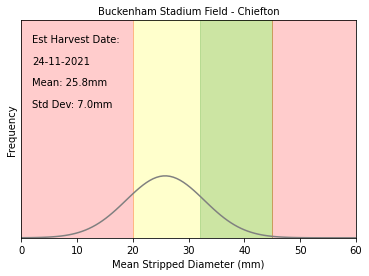

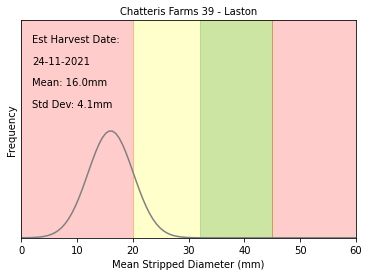

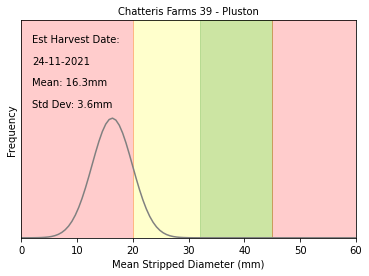

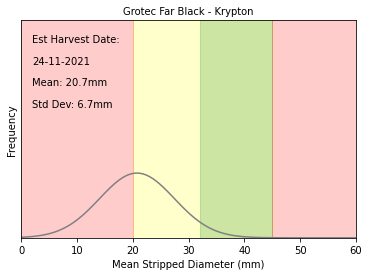

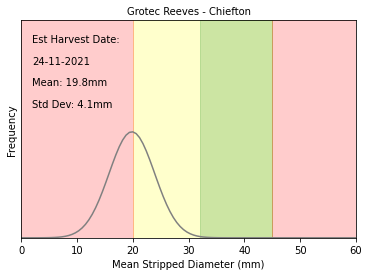

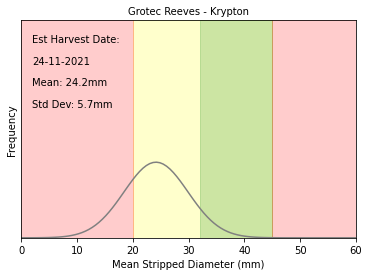

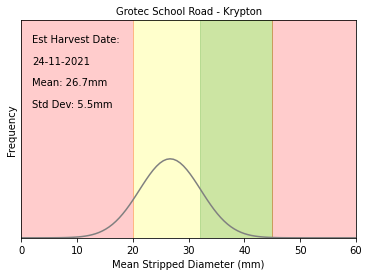

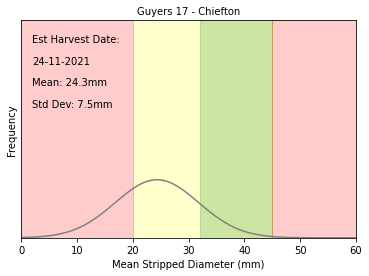

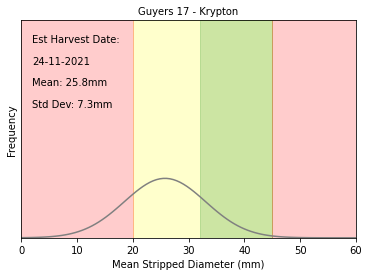

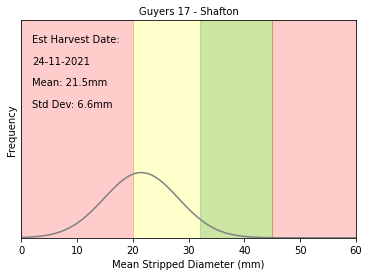

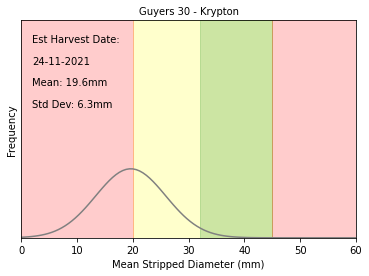

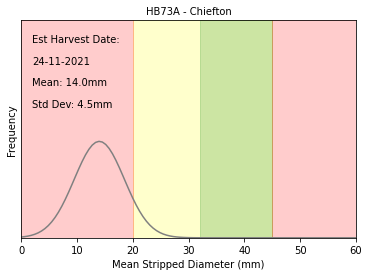

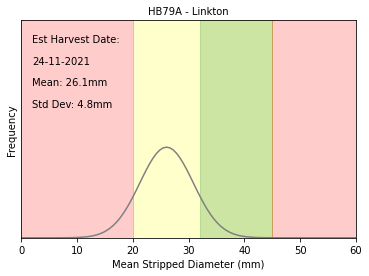

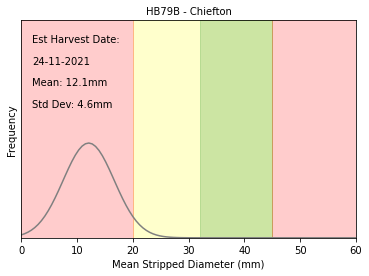

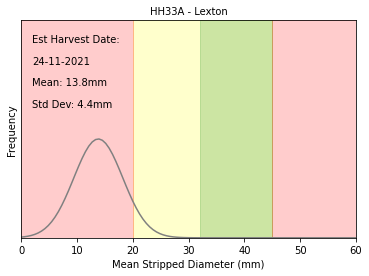

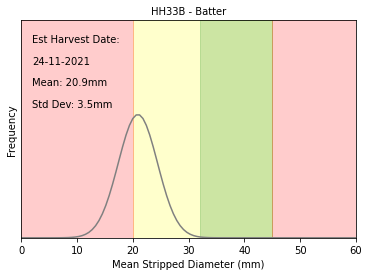

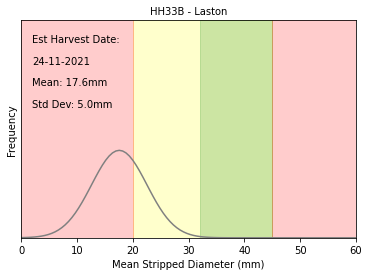

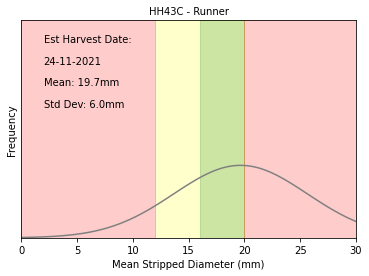

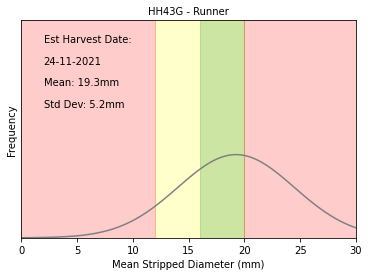

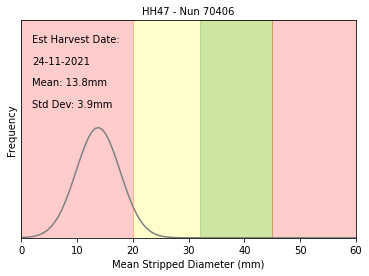

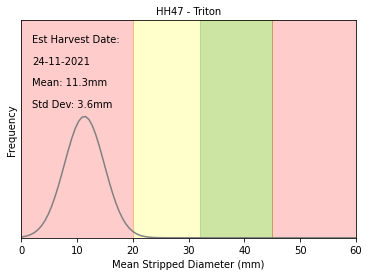

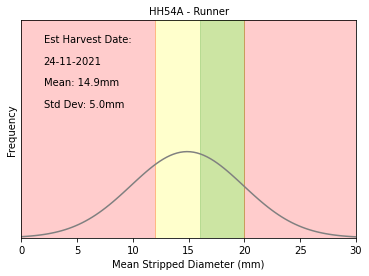

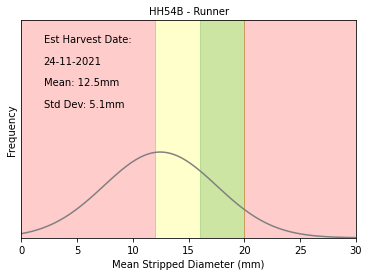

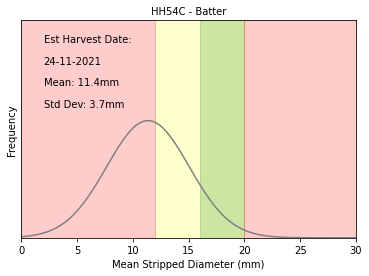

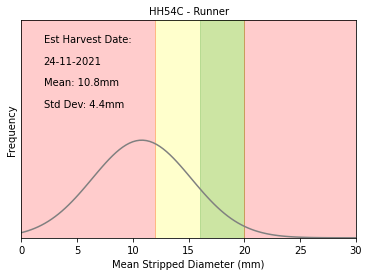

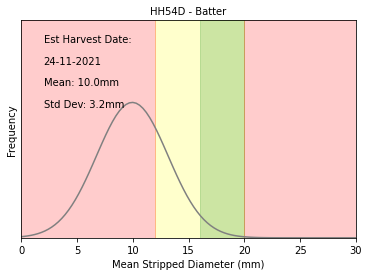

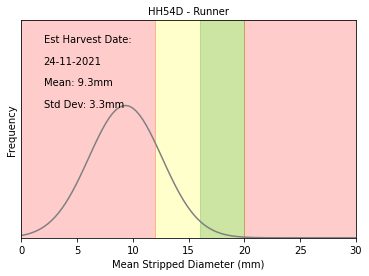

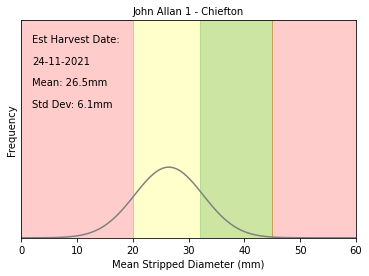

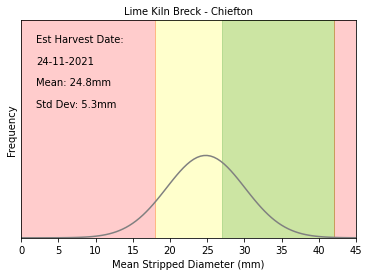

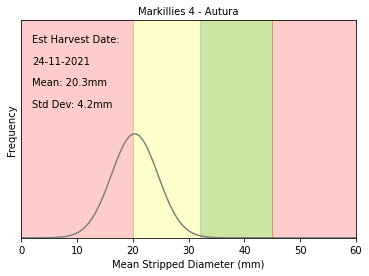

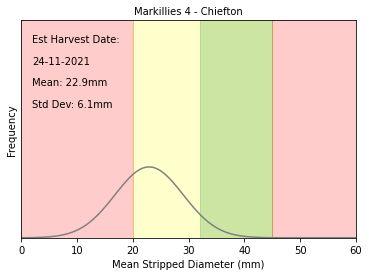

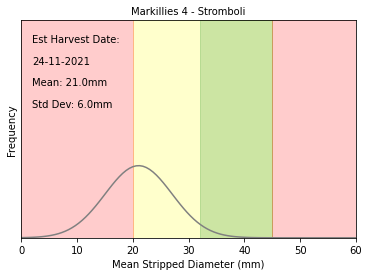

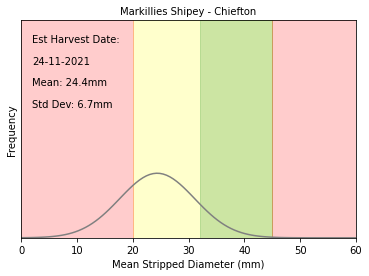

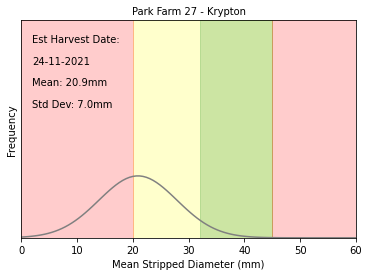

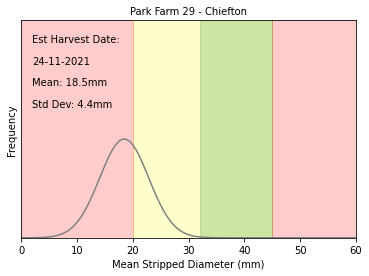

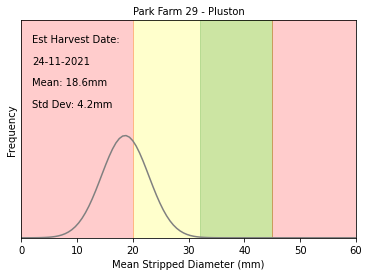

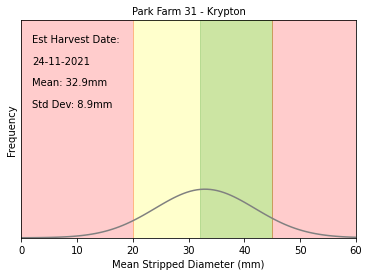

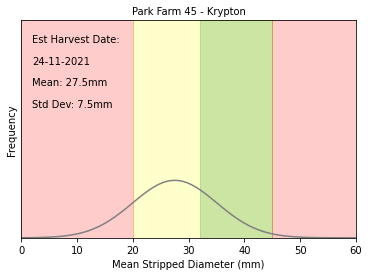

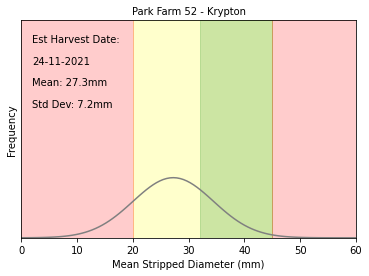

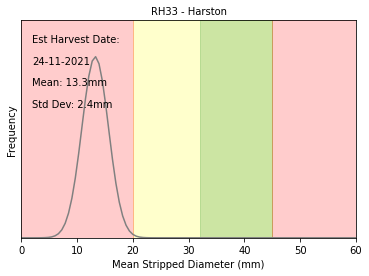

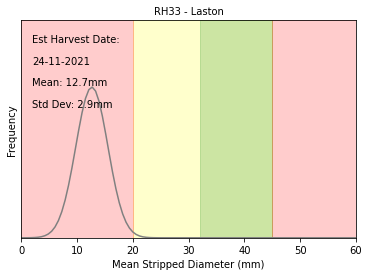

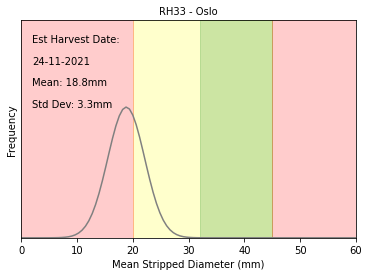

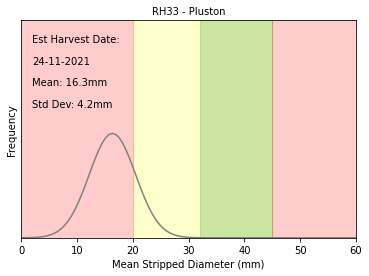

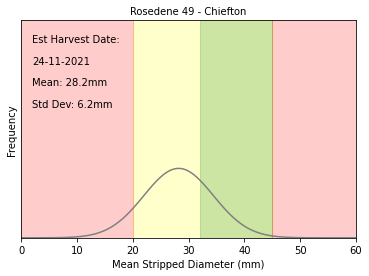

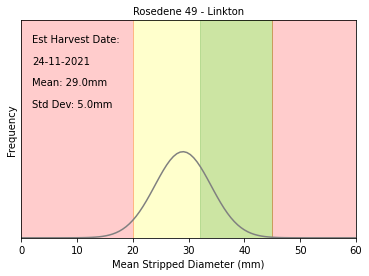

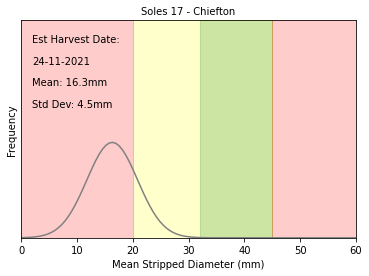

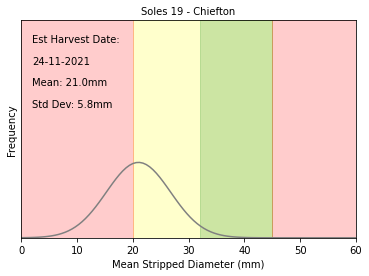

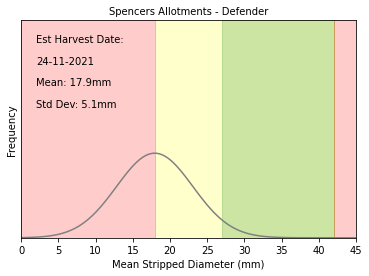

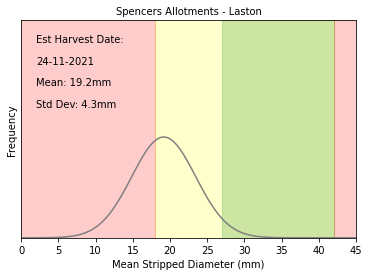

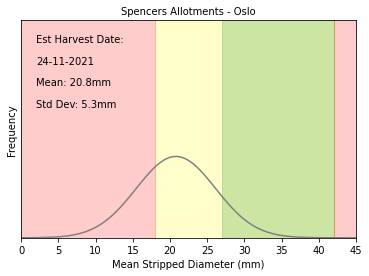

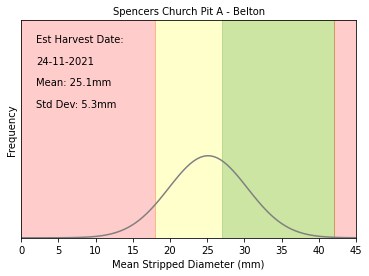

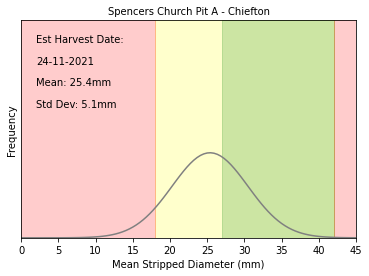

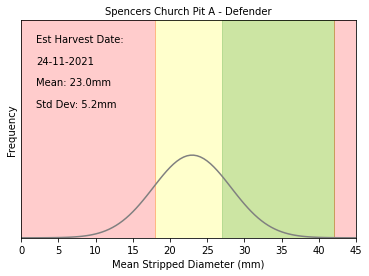

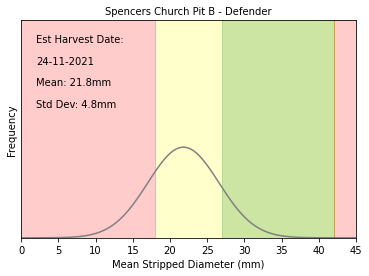

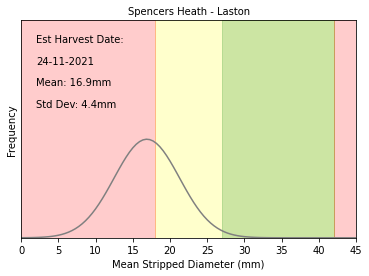

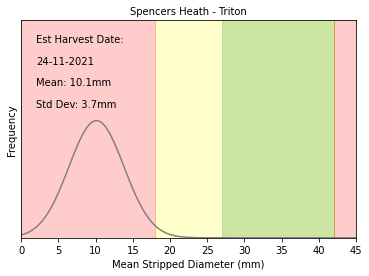

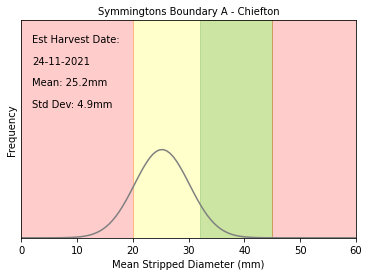

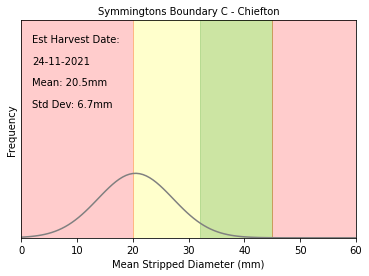

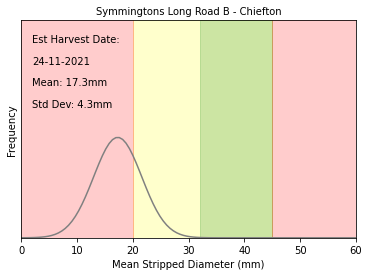

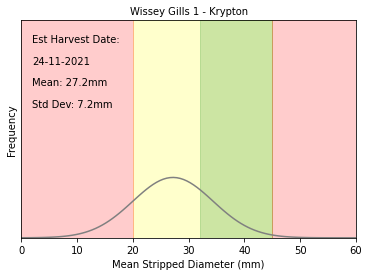

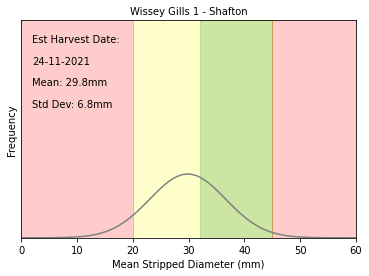

In [5]:
filt_zone_data = zone_data.copy()
filt_zone_data = filt_zone_data.loc[(filt_zone_data['planting_date'] > season)]
filt_zone_data = filt_zone_data.fillna(value = 0, axis = 1)
filt_zone_data = filt_zone_data.loc[(filt_zone_data['harvest_date'] == 0)]

field_variety_list = list(filt_zone_data['fieldvariety'])
field_variety_list = list(set(field_variety_list))
field_variety_list = sorted(field_variety_list)

for fv in field_variety_list:
    df = filt_zone_data.loc[(filt_zone_data['fieldvariety'] == fv)]
    df = df.reset_index(drop=True)
    inputs = mode(df['inputs'])
    
    
    if inputs == 'Baby':
        x_min = 0.0
        x_max = 30.0
        up_spec = 20
        low_spec = 12
        low_opt = 16
        
    elif inputs == 'Organic':
        x_min = 0.0
        x_max = 45.0
        up_spec = 42
        low_spec = 18
        low_opt = 27
        
    elif inputs == 'Conventional':
        x_min = 0.0
        x_max = 60.0
        up_spec = 45
        low_spec = 20
        low_opt = 32
        
    mean = df['est_mean_diameter'].mean()
    pooled_std = df['est_std_dev_diameter'].mean()
    
    ### Is this standard deviation calculation correct???
    ### No, but its as close as you'll get.
    
    ### NEED TO APPEND SD, MEAN AND FV VALUES TO DF AND EXPORT AT THE END AS CSV.

    x = np.linspace(x_min, x_max, 100)
    y = ss.norm.pdf(x,mean,pooled_std)
    c = 'grey'
    plt.plot(x,y, color=c)
    plt.grid()
    plt.xlim(x_min,x_max)
    plt.ylim(0,0.20)
    
    today = datetime.today()
    d = today + timedelta(days=future_days)
    d = d.strftime('%d-%m-%Y')
    
    plt.text(x=2, y=0.18, s='Est Harvest Date:')
    plt.text(x=2, y=0.16, s=d)
    plt.text(x=2, y=0.14, s=f'Mean: {mean:.1f}mm')
    plt.text(x=2, y=0.12, s=f'Std Dev: {pooled_std:.1f}mm')
    
    plt.grid(False)
    
    plt.axvspan(low_spec, up_spec, color='yellow', alpha=0.2)
    plt.axvspan(low_opt, up_spec, color='green', alpha=0.2)
    plt.axvspan(0, low_spec, color='red', alpha=0.2)
    plt.axvspan(up_spec, x_max, color='red', alpha=0.2)
    
    plt.title(f'{fv}',fontsize=10)
    
    new_fv = fv.replace('/', '-')

    plt.xlabel('Mean Stripped Diameter (mm)')
    plt.tick_params(left = False, labelleft = False)
    plt.ylabel('Frequency')
    plt.savefig(f"{cw_directory}//Distributions//{new_fv} Population Distribution.png",dpi=600)
    plt.show()